In [ ]:
!pip install dtwalign dtaidistance

In [7]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from dtwalign import dtw
from dtaidistance import dtw_visualisation as dtwvis

from scipy.stats import zscore

## Preparando a base de dados

In [8]:
# Realizando a leitura dos dados
par = pd.read_csv("/content/par_sintetico_sismica.csv")
par.head()

,Tempo (ms),(B) INTERCEPT_ORIG_TEMPO,(C) TVD (metros),(A) PSTM_COR
0,0,0.0,27.0,-715.894287
1,4,0.0,30.0,-510.063721
2,8,0.0,33.0,-320.804443
3,12,0.0,36.0,-457.618164
4,16,0.0,39.0,-444.709473


In [9]:
# Visualizando ambas as séries temporais
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=par['(A) PSTM_COR'], name='sísmico'), row=1, col=1)
fig.add_trace(go.Scatter(y=par['(B) INTERCEPT_ORIG_TEMPO'], name='sintético'), row=2, col=1)

fig.show()

In [10]:
# Recortando o traço sísmico
sism = par['(A) PSTM_COR'][718:1313].to_numpy()
sism_std = zscore(sism) # normalizando os dados

# Recortando o traço sintético
sint = par['(B) INTERCEPT_ORIG_TEMPO'][345:921].to_numpy()
sint_std = zscore(sint) # normalizando os dados


fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=sism_std, name='sísmico'), row=1, col=1)
fig.add_trace(go.Scatter(y=sint_std, name='sintético'), row=2, col=1)

fig.show()

## DTW

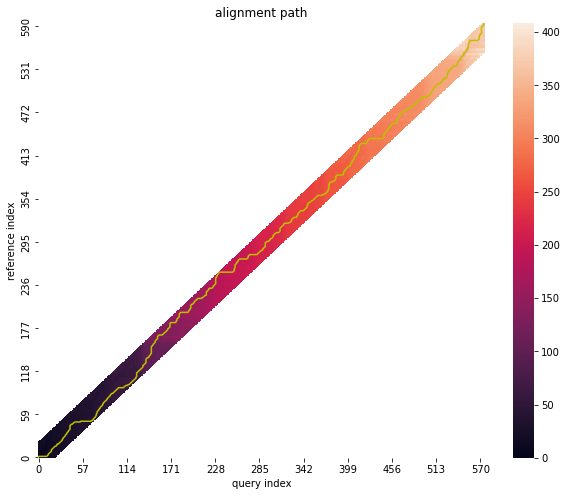

In [11]:
# Executa o DTW com uma janela de Sakoechiba com tamanho 20
res = dtw(sint_std, sism_std, window_type="sakoechiba", window_size=20)

# Visualiza o path DTW obtido
plt.rcParams['figure.figsize'] = (10,8)
res.plot_path()

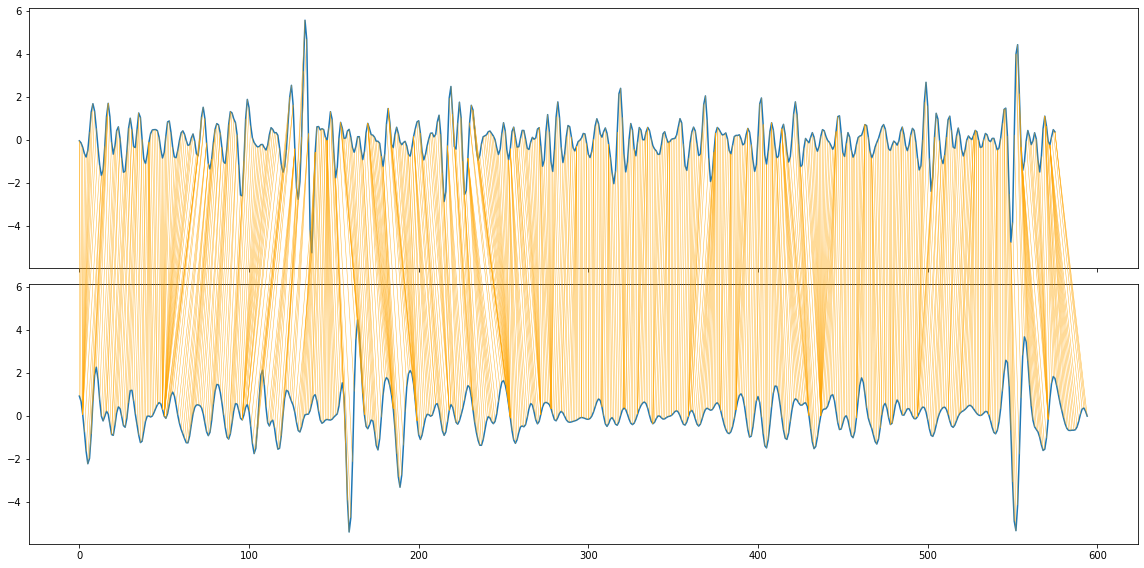

In [12]:
# Apresenta os alinhamento realizado pelo DTW
plt.rcParams['figure.figsize'] = (16,8)
dtwvis.plot_warping(sint_std, sism_std, res.path)
plt.show()

In [13]:
# Obtem o caminho de distorção da query (traço sintético)
query_path = res.get_warping_path(target="query")
sint_dtw = sint_std[query_path] # aplica a distorção obtida

# Calcula o coeficiente de correlação de Pearson
np.corrcoef(sint_dtw, sism_std)

array([[1.        , 0.77866239],
       [0.77866239, 1.        ]])

## DDTW

Numa tentativa de tentar maximizar a ocorrência de alinhamento dos formatos da séries temporais, em vez de alinhar pontos, o Derivative Dynamic Time Warping (DDTW) estima a derivativa das séries temporais antes de realizar o alinhamento.

$$
D_{x}[q] = \frac{(q_{i} - q_{i-1}) + ((q_{i+1} - q_{i-1}) / 2)}{2}
$$

para $1 < i < m$

In [14]:
# Implementação da função derivativa
def derivative(x):
  dx = [0 if i == 0 or i == len(x)-1 else ((x[i]-x[i-1]) + ((x[i+1]-x[i-1]) / 2)) / 2 for i in range(x.shape[0])]
  dx[0], dx[-1] = dx[1], dx[-2]

  return np.array(dx)

In [15]:
# Calcula-se a derivativa de ambas as séries 
d_sism = derivative(sism_std)
d_sint = derivative(sint_std)

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=sism_std, mode='lines', name='sintético'), row=1, col=1)
fig.add_trace(go.Scatter(y=d_sism, mode='lines', name='d_sintético'), row=1, col=1)

fig.add_trace(go.Scatter(y=sint_std, mode='lines', name='sismico'), row=2, col=1)
fig.add_trace(go.Scatter(y=d_sint, mode='lines', name='d_sismico'), row=2, col=1)

fig.show()

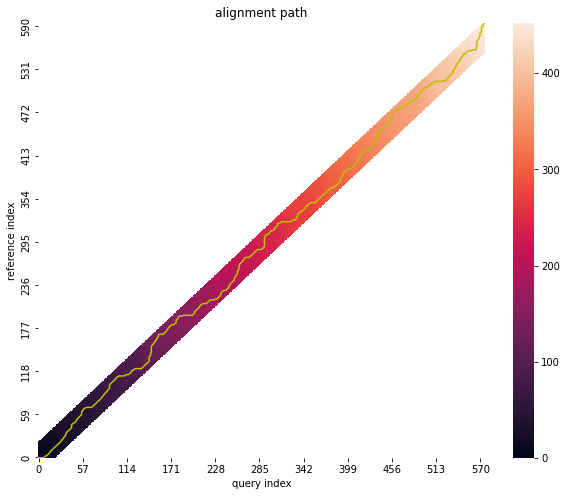

In [16]:
# Calcula-se a distância DTW entre as séries derivadas
res_d = dtw(d_sint, d_sism, dist=lambda x,y: np.sqrt(abs(x - y)), window_type="sakoechiba", window_size=20)

# Visualização do path DTW encontrado
plt.rcParams['figure.figsize'] = (10,8)
res_d.plot_path()

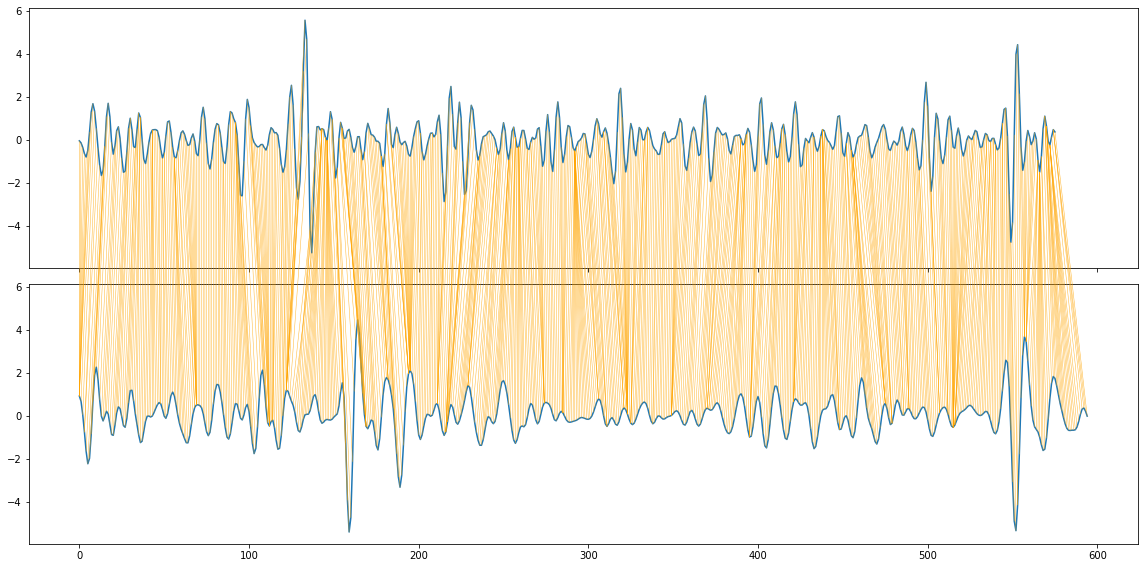

In [17]:
# Visualização do alinhamento obtido com DDTW
plt.rcParams['figure.figsize'] = (16,8)
dtwvis.plot_warping(sint_std, sism_std, res_d.path)
plt.show()

In [18]:
# Obtem o caminho de distorção da query (traço sintético)
query_path = res_d.get_warping_path(target="query")
sint_ddtw = sint_std[query_path]

# Calcula o coeficiente de correlação de Pearson
np.corrcoef(sint_ddtw, sism_std)

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning:

invalid value encountered in multiply



array([[1.        , 0.52724395],
       [0.52724395, 1.        ]])

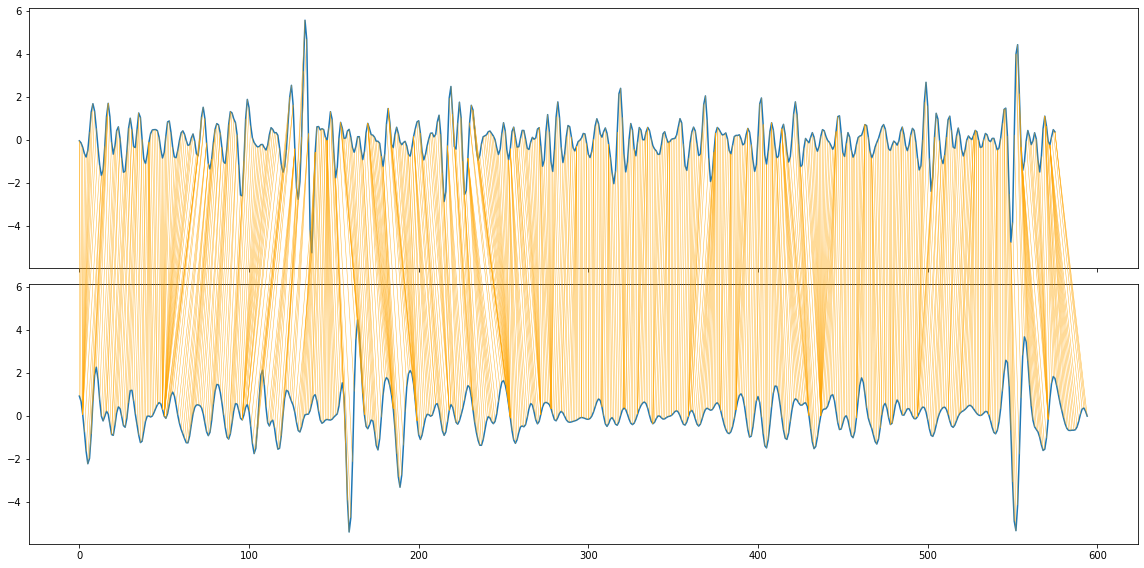

In [19]:
# Visualização do alinhamento obtido com DTW padrão (para fins de comparação)
plt.rcParams['figure.figsize'] = (16,8)
dtwvis.plot_warping(sint_std, sism_std, res.path)
plt.show()

## TWDTW

**Referência:**
- Maus, V., Câmara, G., Cartaxo, R., Sanchez, A., Ramos, F.M. and De Queiroz, G.R., 2016. A time-weighted dynamic time warping method for land-use and land-cover mapping. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 9(8), pp.3729-3739.

In [20]:
from dtwalign import dtw_from_distance_matrix
from scipy.spatial.distance import cdist

A fim de minimizar a ocorrência de distorções muito grandes o TWDTW utiliza-se de uma função logistica para penalizar distorções muito grandes. 

**Logistic**
$$
w_{i,j} = \frac{1}{1 + e^{-\alpha(g(t_i, t_j))-\beta}}
$$

sendo $g(t_i, t_j)$ é o tempo decorrido

In [21]:
# Função custo utilizada para calcular a matriz de distância
def tcost(q, t, alpha=0.1, beta=100):
  """
  q -> query
  t -> template
  """
  cost = np.zeros((len(q), len(t)))

  for i in range(len(q)):
    for j in range(len(t)):
      # calculo da função logistica
      logist_cost = 1 / (1 + np.exp(-alpha * (abs(i - j) - beta)))
      
      # a distancia é dada pela diferença entre as séries temporais mais o custo de distorção
      cost[i,j] = abs(q[i] - t[j]) + logist_cost

  return cost

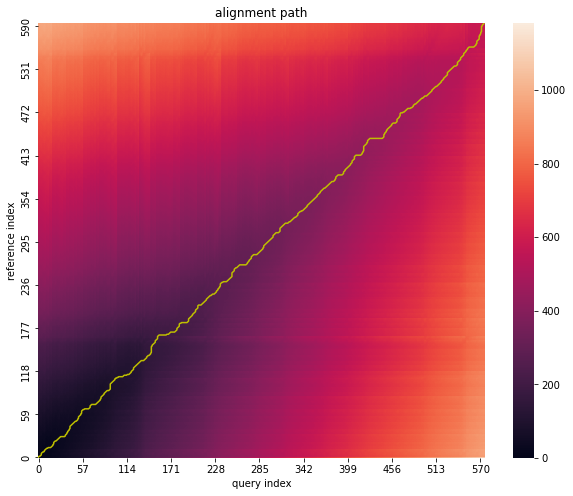

In [22]:
# Calcula a matriz de distância
dist_nonlin = tcost(sint_std, sism_std, alpha=0.1, beta=20)

# Computa a matriz DTW
res_tw = dtw_from_distance_matrix(dist_nonlin)

# Visualiza o caminho encontrado pelo TWDTW
plt.rcParams['figure.figsize'] = (10,8)
res_tw.plot_path()

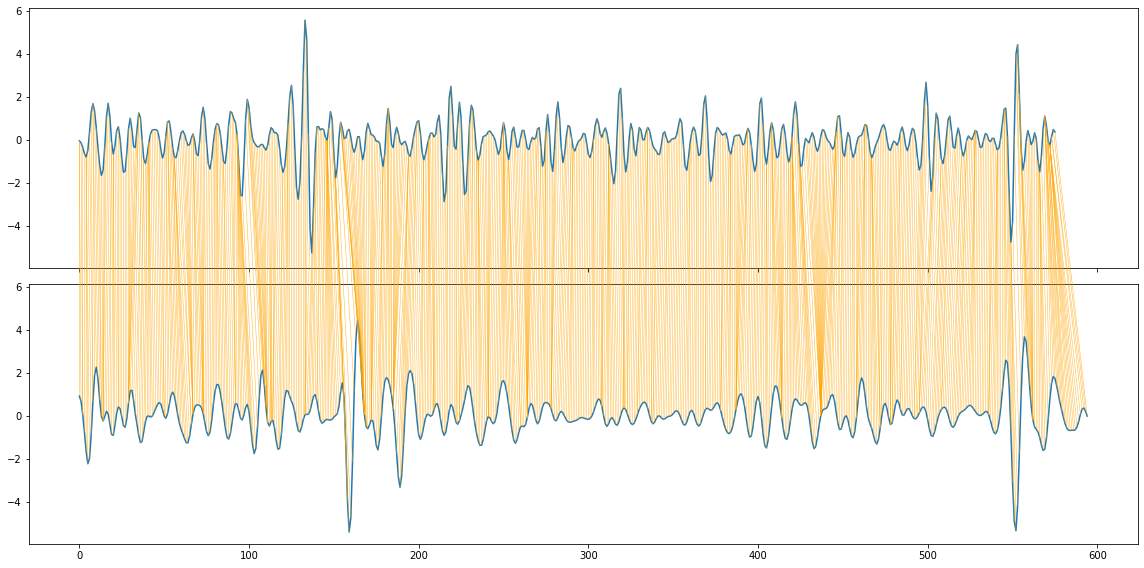

In [23]:
# Visualiza o alinhamento realizado
plt.rcParams['figure.figsize'] = (16,8)
dtwvis.plot_warping(sint_std, sism_std, res_tw.path)
plt.show()

In [24]:
# Obtem o caminho de distorção da query (traço sintético)
query_path = res_tw.get_warping_path(target="query")
sint_twdtw = sint_std[query_path]

# Calcula o coeficiente de correlação de Pearson
np.corrcoef(sint_twdtw, sism_std)

array([[1.        , 0.70431968],
       [0.70431968, 1.        ]])

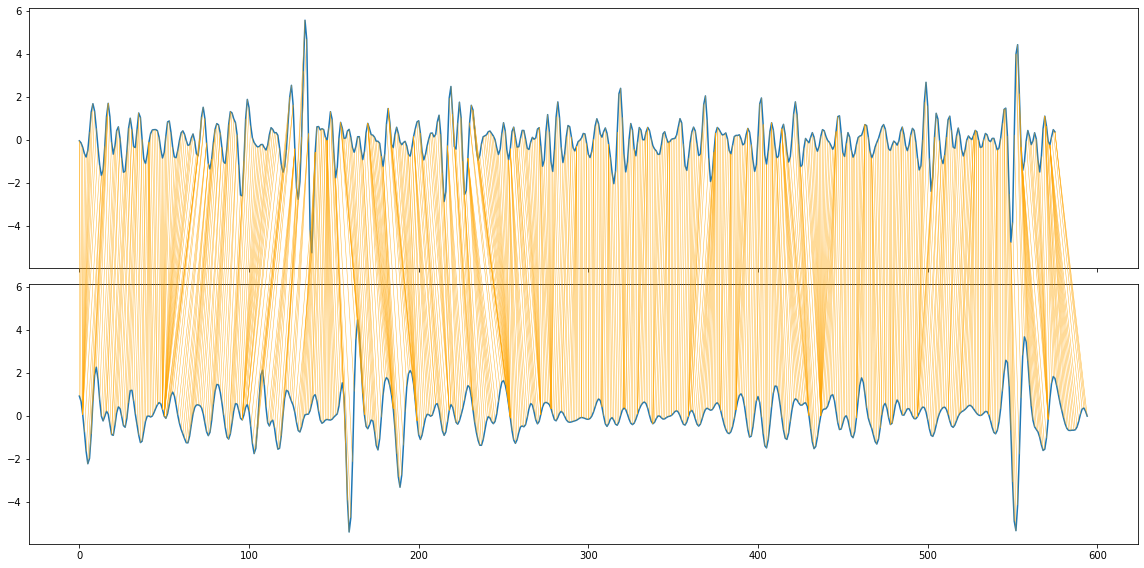

In [ ]:
# Visualização do alinhamento obtido com DTW padrão (para fins de comparação)
plt.rcParams['figure.figsize'] = (16,8)
dtwvis.plot_warping(sint_std, sism_std, res.path)
plt.show()

## Smooth-DTW (Não funcional para aplicações reais!)


Compton, S. and Hale, D., 2014. Estimating VP/VS ratios using smooth dynamic image warping. Geophysics, 79(6), pp.V201-V215.

In [25]:
# Cria um série de distorção utilizando a função cosseno 
s = np.cos(np.linspace(-np.pi, np.pi, len(sint_std))) * 20
s = s.astype(np.int32)
s_inv = s*-1

# Calcula o traço sintético distorcido
g_sint = np.array([sint_std[i + s[i]] for i in range(sint_std.shape[0])])

In [26]:
# Visualia o traço sintético e o traço sintético distorcido
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(y=s), row=1, col=1)

fig.add_trace(go.Scatter(y=sint_std, name='sintetico'), row=2, col=1)
fig.add_trace(go.Scatter(y=g_sint, name='shifted'), row=2, col=1)

fig.show()

In [27]:
# Função para o calcula da matriz de erro/distância
def error_matrix(f, g, s):
  N = len(f)
  S = len(s)
  e = np.full((N, S), np.inf)

  for i in range(N):
    for l in range(S):
      shift = i + s[l]
      
      # Extrapola o erro de indices negativos
      if shift < 0:
        e[i,l] = (f[abs(s[l])] - g[0])**2
      
      # Extrapola o erro de indices maiores que o tamanho da série de referência
      elif shift > N-1:
        e[i,l] = (f[-s[l]] - g[N-1])**2
      else:
        e[i,l] = (f[i] - g[shift])**2

  return e

In [28]:
# Cria o vetor de distorção
s_intrv = np.arange(-25, 25, 1)

# Calcula a matriz de erro/distância
e = error_matrix(sint_std, g_sint, s_intrv)

fig = go.Figure(data=go.Heatmap(z=e.T)) 
fig.show()

In [29]:
def interp_lin(x: int, x1: tuple, x2: tuple):
  """
  Interpolate a point (x,y) above a line.

  Parameters:
  ----------
  x : int
    Position of the point to be interpolated.
  x1: tuple(int, int)
    Line start point.
  x2: tuple(int, int)
    Line end point.

  Return:
  ----------
  y : int
    Interpolated y.

  """
  x_ratio = (x - x1[0]) / (x2[0] - x1[0])
  y = x1[1]*(1 - x_ratio) + x2[1]*x_ratio
  return int(round(y))


In [30]:
def smooth_dtw(e: np.array, h: int = 1):
  """
  Smooth Dynamic Time Warping (Smooth DTW)

  Parameters:
  ----------
  e : 2D-array
    Computed error matrix.
  h: int
    Smooth size.

  Return:
  ----------
  d : 2D-array
    Distance matrix.
  u : 1D-array
    Lag index
  """
  nl = e.shape[1]

  j = [i for i in range(0, e.shape[0], h)]
  j.append(e.shape[0] - 1)

  ni = len(j)

  d = np.full((ni, nl), np.inf) # matriz de distãncia
  m = np.full((ni, nl), np.inf) # movimentos realizados
  u = np.full((ni,), np.inf, np.int) # caminho ótimo
  r = np.ones((ni,), np.int) # região pulada

  # Inicialiação da matriz
  for l in range(nl):
    d[0,l] = e[0,l]

  # Calcula a matriz de distância acumulada 
  for i in range(1, ni):
    for l in range(nl):
      dl = np.inf

      # Intervalo permitido de distorção (strain control)
      ql = max(0, l - h)
      qu = min(nl, l + h + 1)

      for q in range(ql, qu):
        dq = d[i-1, q]

        p_range = j[i] - j[i-1]
        r[i] = p_range

        # Calcula o custo da região interna do bloco 
        for p in range(p_range):
          x = j[i]-p
          # utiliza-se uma interpolação linear para obter a coluna correta
          y = interp_lin(x, x1=(j[i], l), x2=(j[i-1], q))

          # somatório do erro da distorção na região interna do bloco
          dq += e[x, y]

        if dq < dl:
          dl, ml = dq, q

      d[i,l] = dl
      m[i,l] = ml

  i = ni - 1
  di = np.inf

  # Identifica o caminho com a menor distância
  for l in range(nl):
    if d[i,l] < di:
      di = d[i,l]
      u[i] = l

  # Backtrack do menor caminho
  while i > 0:
    u[i-1] = m[i, u[i]]
    i -= 1

  return d, u


In [31]:
# Calcula o SDTW da matriz de distância
d, u = smooth_dtw(e, 8)

# Interpola o caminho encontrado uma fez que só temos o path a cada h observações 
# (somente para fins de visualização)
xtmp = [i for i in range(0, 576, 8)] + [575]
interp_u = np.array(np.interp(np.arange(576), xtmp, u), np.int32)


fig = go.Figure()

fig.add_trace(go.Heatmap(z=e.T, name='error'))
fig.add_trace(go.Scatter(y=interp_u, name='shift_path', line={'color': 'white'}))
fig.add_trace(go.Scatter(y=s_inv+25, name='true_shift', line={'color': 'black'}))

fig.update_layout(title='Distance Matrix - DIW')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

In [32]:
# Função para remover o shift estimado pelo SDTW
def remove_shift(g, u, s_intrv):
  return [g[max(0, min(u.shape[0]-1, i + s_intrv[u[i]]))] for i in range(u.shape[0])]


In [33]:
# Recupera o sinal original (sem shift)
recovered = remove_shift(g_sint, interp_u, s_intrv)

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(y=sint_std, name='f'), row=1, col=1)
fig.add_trace(go.Scatter(y=g_sint, name='g'), row=1, col=1)
fig.add_trace(go.Scatter(y=recovered, name='recovered'), row=1, col=1)

fig.show()